In [ ]:
import math
from enum import Enum

import matplotlib.pyplot as plt
import numpy as np

show_animation = True


def dwa_control(x, config, goal, ob):
    """
    Dynamic Window Approach control
    """
    dw = calc_dynamic_window(x, config)

    u, trajectory = calc_control_and_trajectory(x, dw, config, goal, ob)

    return u, trajectory

In [ ]:
class RobotType(Enum):
    circle = 0
    rectangle = 1


class Config:
    """
    simulation parameter class
    """

    def __init__(self):
        # robot parameter
        self.max_speed = 1.0  # [m/s]
        self.min_speed = -0.5  # [m/s]
        self.max_yaw_rate = 40.0 * math.pi / 180.0  # [rad/s]
        self.max_accel = 0.2  # [m/ss]
        self.max_delta_yaw_rate = 40.0 * math.pi / 180.0  # [rad/ss]
        self.v_resolution = 0.01  # [m/s]
        self.yaw_rate_resolution = 0.1 * math.pi / 180.0  # [rad/s]
        self.dt = 0.1  # [s] Time tick for motion prediction
        self.predict_time = 3.0  # [s]
        self.to_goal_cost_gain = 0.15
        self.speed_cost_gain = 1.0
        self.obstacle_cost_gain = 1.0
        self.robot_stuck_flag_cons = 0.001  # constant to prevent robot stucked
        self.robot_type = RobotType.circle

        # if robot_type == RobotType.circle
        # Also used to check if goal is reached in both types
        self.robot_radius = 1.0  # [m] for collision check

        # if robot_type == RobotType.rectangle
        self.robot_width = 0.5  # [m] for collision check
        self.robot_length = 1.2  # [m] for collision check
        # obstacles [x(m) y(m), ....]
        self.ob = np.array([[-1, -1],
                            [0, 2],
                            [4.0, 2.0],
                            [5.0, 4.0],
                            [5.0, 5.0],
                            [5.0, 6.0],
                            [5.0, 9.0],
                            [8.0, 9.0],
                            [7.0, 9.0],
                            [8.0, 10.0],
                            [9.0, 11.0],
                            [12.0, 13.0],
                            [12.0, 12.0],
                            [15.0, 15.0],
                            [13.0, 13.0]
                            ])

    @property
    def robot_type(self):
        return self._robot_type

    @robot_type.setter
    def robot_type(self, value):
        if not isinstance(value, RobotType):
            raise TypeError("robot_type must be an instance of RobotType")
        self._robot_type = value


config = Config()


def motion(x, u, dt):
    """
    motion model
    """

    x[2] += u[1] * dt
    x[0] += u[0] * math.cos(x[2]) * dt
    x[1] += u[0] * math.sin(x[2]) * dt
    x[3] = u[0]
    x[4] = u[1]

    return x


def calc_dynamic_window(x, config):
    """
    calculation dynamic window based on current state x
    """

    # Dynamic window from robot specification
    Vs = [config.min_speed, config.max_speed,
          -config.max_yaw_rate, config.max_yaw_rate]

    # Dynamic window from motion model
    Vd = [x[3] - config.max_accel * config.dt,
          x[3] + config.max_accel * config.dt,
          x[4] - config.max_delta_yaw_rate * config.dt,
          x[4] + config.max_delta_yaw_rate * config.dt]

    #  [v_min, v_max, yaw_rate_min, yaw_rate_max]
    dw = [max(Vs[0], Vd[0]), min(Vs[1], Vd[1]),
          max(Vs[2], Vd[2]), min(Vs[3], Vd[3])]

    return dw


In [ ]:
def predict_trajectory(x_init, v, y, config):
    """
    predict trajectory with an input
    """

    x = np.array(x_init)
    trajectory = np.array(x)
    time = 0
    while time <= config.predict_time:
        x = motion(x, [v, y], config.dt)
        trajectory = np.vstack((trajectory, x))
        time += config.dt

    return trajectory


def calc_control_and_trajectory(x, dw, config, goal, ob):
    """
    calculation final input with dynamic window
    """

    x_init = x[:]
    min_cost = float("inf")
    best_u = [0.0, 0.0]
    best_trajectory = np.array([x])

    # evaluate all trajectory with sampled input in dynamic window
    for v in np.arange(dw[0], dw[1], config.v_resolution):
        for y in np.arange(dw[2], dw[3], config.yaw_rate_resolution):

            trajectory = predict_trajectory(x_init, v, y, config)
            # calc cost
            to_goal_cost = config.to_goal_cost_gain * calc_to_goal_cost(trajectory, goal)
            speed_cost = config.speed_cost_gain * (config.max_speed - trajectory[-1, 3])
            ob_cost = config.obstacle_cost_gain * calc_obstacle_cost(trajectory, ob, config)

            final_cost = to_goal_cost + speed_cost + ob_cost

            # search minimum trajectory
            if min_cost >= final_cost:
                min_cost = final_cost
                best_u = [v, y]
                best_trajectory = trajectory
                if abs(best_u[0]) < config.robot_stuck_flag_cons \
                        and abs(x[3]) < config.robot_stuck_flag_cons:
                    # to ensure the robot do not get stuck in
                    # best v=0 m/s (in front of an obstacle) and
                    # best omega=0 rad/s (heading to the goal with
                    # angle difference of 0)
                    best_u[1] = -config.max_delta_yaw_rate
    return best_u, best_trajectory


def calc_obstacle_cost(trajectory, ob, config):
    """
    calc obstacle cost inf: collision
    """
    ox = ob[:, 0]
    oy = ob[:, 1]
    dx = trajectory[:, 0] - ox[:, None]
    dy = trajectory[:, 1] - oy[:, None]
    r = np.hypot(dx, dy)

    if config.robot_type == RobotType.rectangle:
        yaw = trajectory[:, 2]
        rot = np.array([[np.cos(yaw), -np.sin(yaw)], [np.sin(yaw), np.cos(yaw)]])
        rot = np.transpose(rot, [2, 0, 1])
        local_ob = ob[:, None] - trajectory[:, 0:2]
        local_ob = local_ob.reshape(-1, local_ob.shape[-1])
        local_ob = np.array([local_ob @ x for x in rot])
        local_ob = local_ob.reshape(-1, local_ob.shape[-1])
        upper_check = local_ob[:, 0] <= config.robot_length / 2
        right_check = local_ob[:, 1] <= config.robot_width / 2
        bottom_check = local_ob[:, 0] >= -config.robot_length / 2
        left_check = local_ob[:, 1] >= -config.robot_width / 2
        if (np.logical_and(np.logical_and(upper_check, right_check),
                           np.logical_and(bottom_check, left_check))).any():
            return float("Inf")
    elif config.robot_type == RobotType.circle:
        if np.array(r <= config.robot_radius).any():
            return float("Inf")

    min_r = np.min(r)
    return 1.0 / min_r  # OK


def calc_to_goal_cost(trajectory, goal):
    """
        calc to goal cost with angle difference
    """

    dx = goal[0] - trajectory[-1, 0]
    dy = goal[1] - trajectory[-1, 1]
    error_angle = math.atan2(dy, dx)
    cost_angle = error_angle - trajectory[-1, 2]
    cost = abs(math.atan2(math.sin(cost_angle), math.cos(cost_angle)))

    return cost


def plot_arrow(x, y, yaw, length=0.5, width=0.1):  # pragma: no cover
    plt.arrow(x, y, length * math.cos(yaw), length * math.sin(yaw),
              head_length=width, head_width=width)
    plt.plot(x, y)


def plot_robot(x, y, yaw, config):  # pragma: no cover
    if config.robot_type == RobotType.rectangle:
        outline = np.array([[-config.robot_length / 2, config.robot_length / 2,
                             (config.robot_length / 2), -config.robot_length / 2,
                             -config.robot_length / 2],
                            [config.robot_width / 2, config.robot_width / 2,
                             - config.robot_width / 2, -config.robot_width / 2,
                             config.robot_width / 2]])
        Rot1 = np.array([[math.cos(yaw), math.sin(yaw)],
                         [-math.sin(yaw), math.cos(yaw)]])
        outline = (outline.T.dot(Rot1)).T
        outline[0, :] += x
        outline[1, :] += y
        plt.plot(np.array(outline[0, :]).flatten(),
                 np.array(outline[1, :]).flatten(), "-k")
    elif config.robot_type == RobotType.circle:
        circle = plt.Circle((x, y), config.robot_radius, color="b")
        plt.gcf().gca().add_artist(circle)
        out_x, out_y = (np.array([x, y]) +
                        np.array([np.cos(yaw), np.sin(yaw)]) * config.robot_radius)
        plt.plot([x, out_x], [y, out_y], "-k")

In [ ]:
def main(gx=10.0, gy=10.0, robot_type=RobotType.circle):
    print( " start!!")
    # initial state [x(m), y(m), yaw(rad), v(m/s), omega(rad/s)]
    x = np.array([0.0, 0.0, math.pi / 8.0, 0.0, 0.0])
    # goal position [x(m), y(m)]
    goal = np.array([gx, gy])

    # input [forward speed, yaw_rate]

    config.robot_type = robot_type
    trajectory = np.array(x)
    ob = config.ob
    while True:
        u, predicted_trajectory = dwa_control(x, config, goal, ob)
        x = motion(x, u, config.dt)  # simulate robot
        trajectory = np.vstack((trajectory, x))  # store state history

        if show_animation:
            plt.cla()
            # for stopping simulation with the esc key.
            plt.gcf().canvas.mpl_connect(
                'key_release_event',
                lambda event: [exit(0) if event.key == 'escape' else None])
            plt.plot(predicted_trajectory[:, 0], predicted_trajectory[:, 1], "-g")
            plt.plot(x[0], x[1], "xr")
            plt.plot(goal[0], goal[1], "xb")
            plt.plot(ob[:, 0], ob[:, 1], "ok")
            plot_robot(x[0], x[1], x[2], config)
            plot_arrow(x[0], x[1], x[2])
            plt.axis("equal")
            plt.grid(True)
            plt.pause(0.0001)

        # check reaching goal
        dist_to_goal = math.hypot(x[0] - goal[0], x[1] - goal[1])
        if dist_to_goal <= config.robot_radius:
            print("Goal!!")
            break

    print("Done")
    if show_animation:
        plt.plot(trajectory[:, 0], trajectory[:, 1], "-r")
        plt.plot(ob[:, 0], ob[:, 1], "ok")
        plt.pause(0.0001)

    plt.show()

 start!!


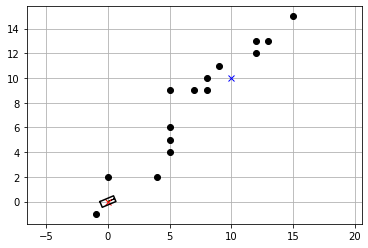

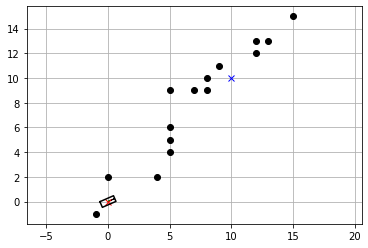

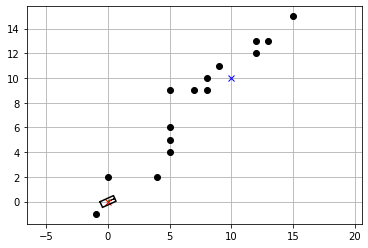

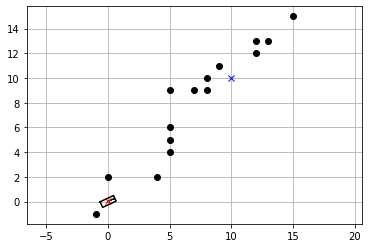

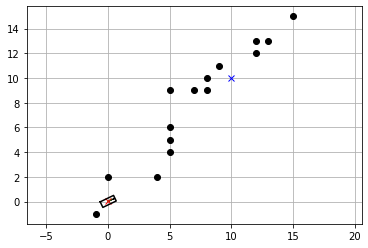

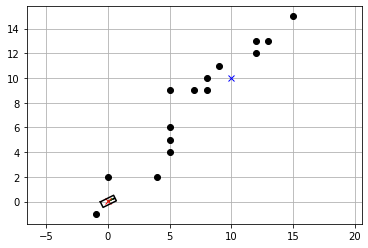

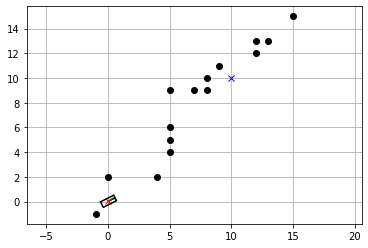

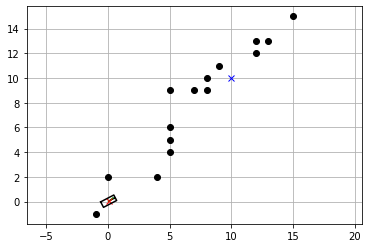

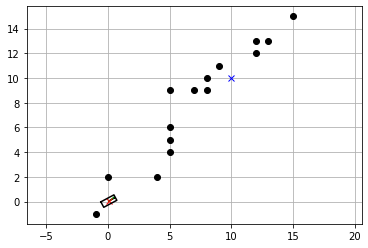

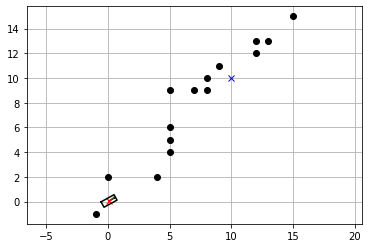

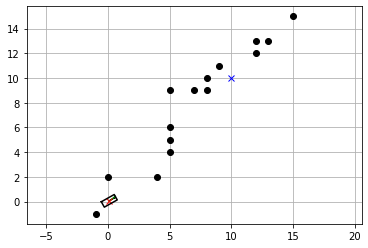

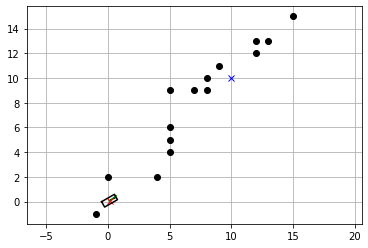

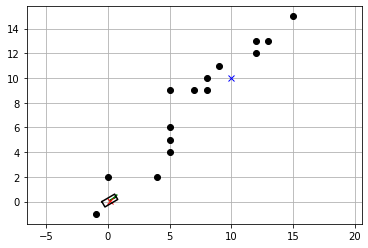

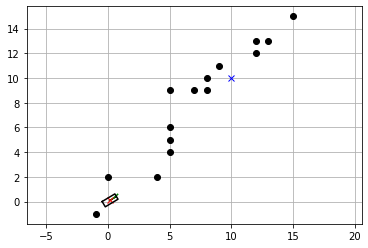

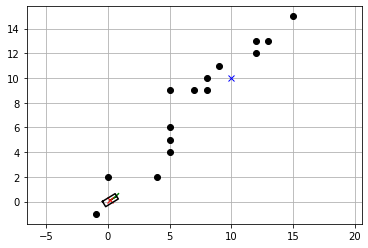

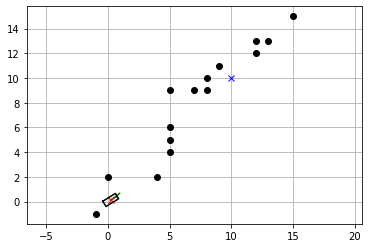

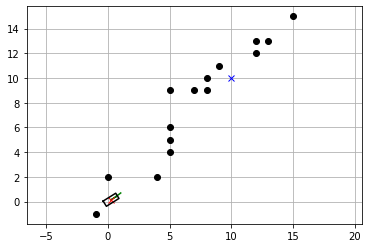

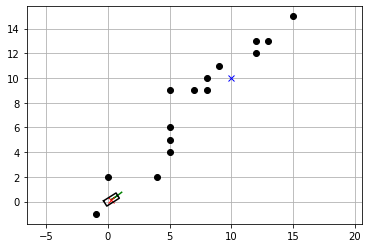

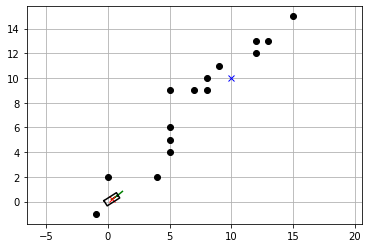

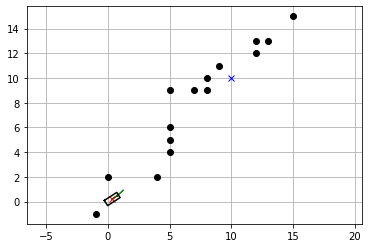

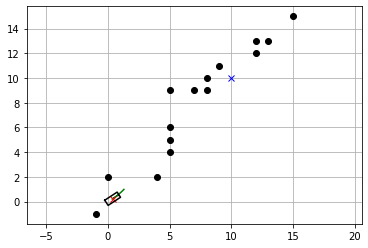

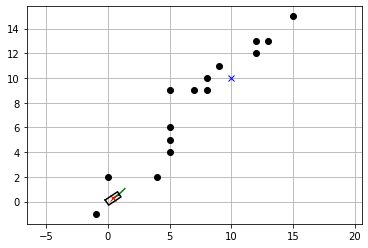

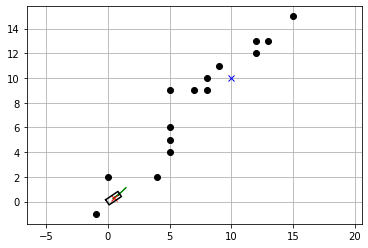

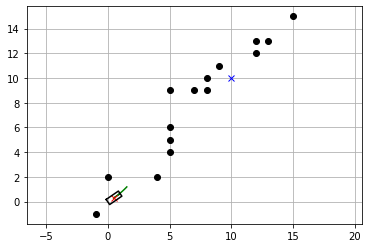

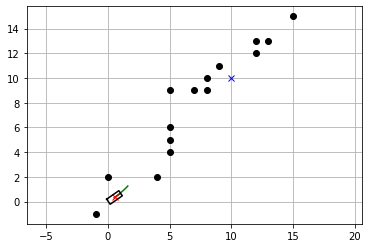

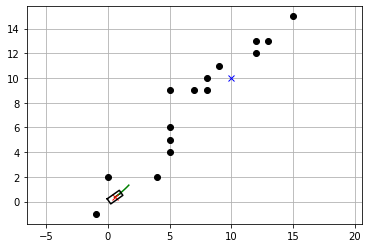

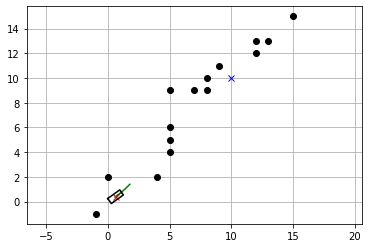

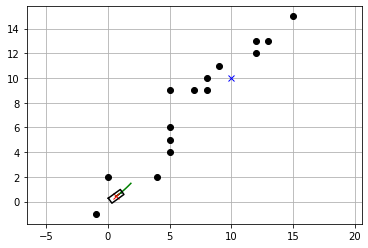

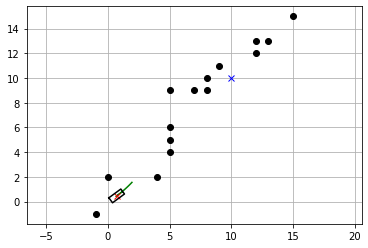

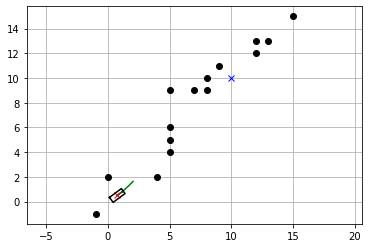

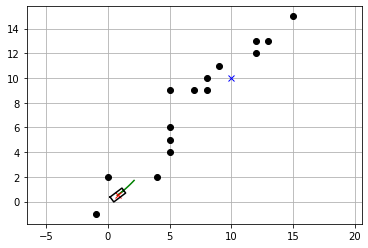

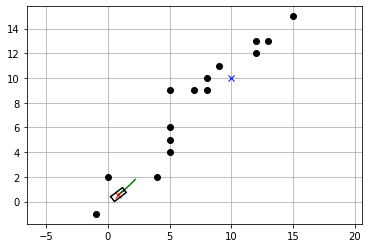

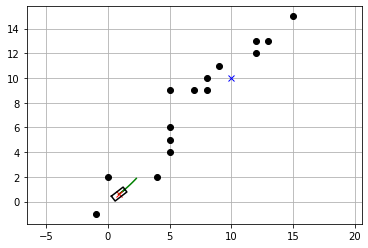

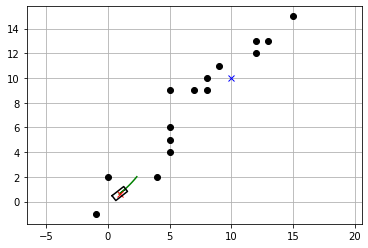

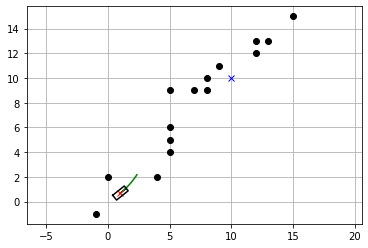

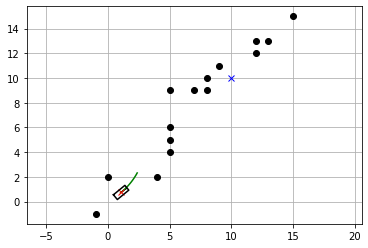

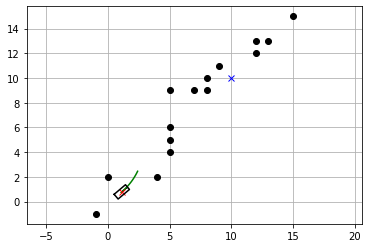

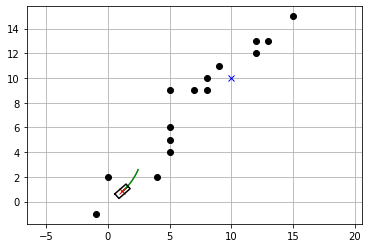

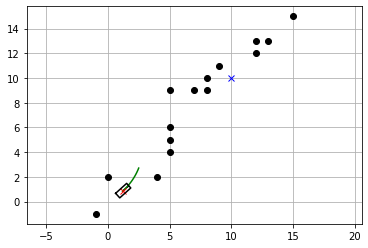

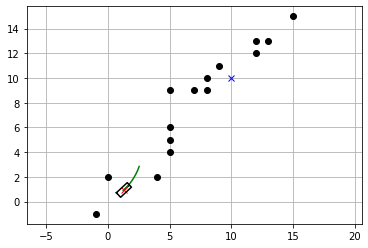

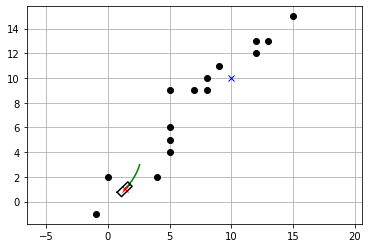

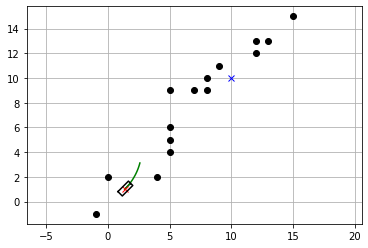

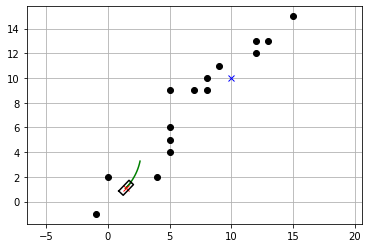

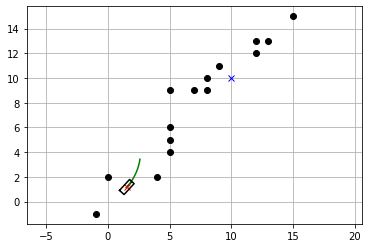

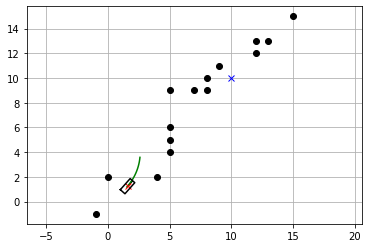

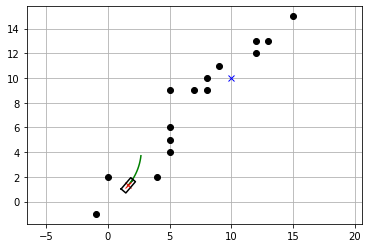

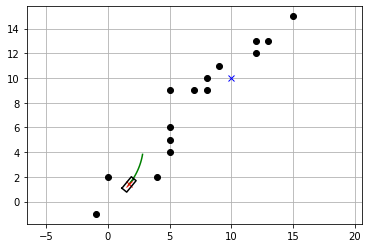

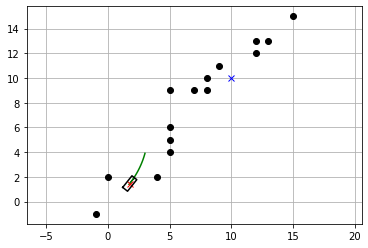

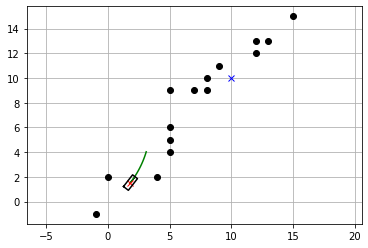

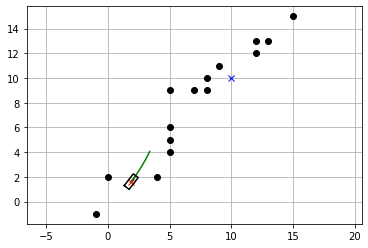

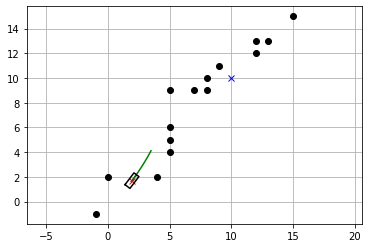

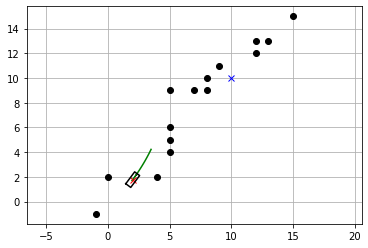

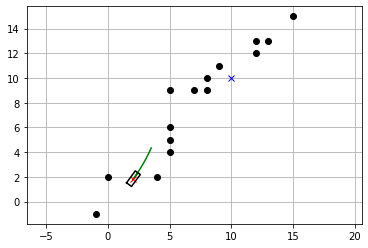

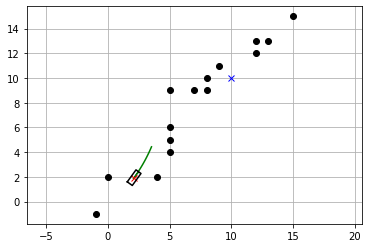

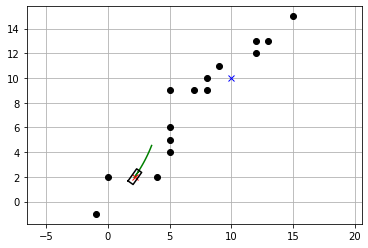

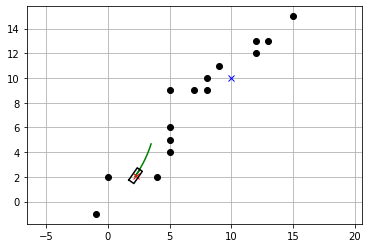

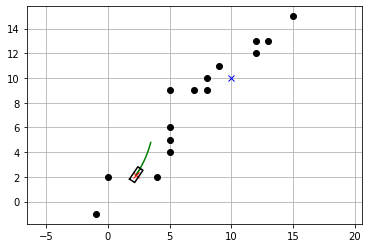

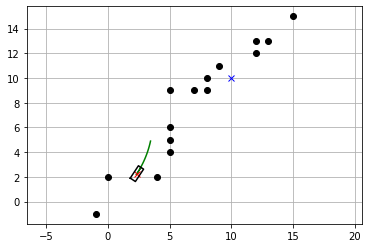

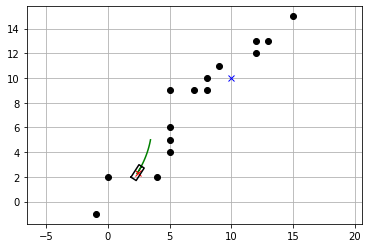

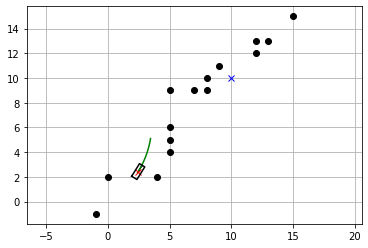

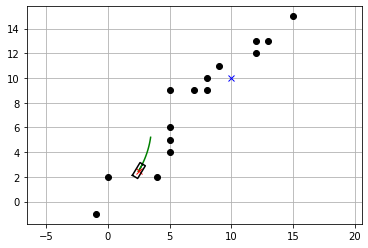

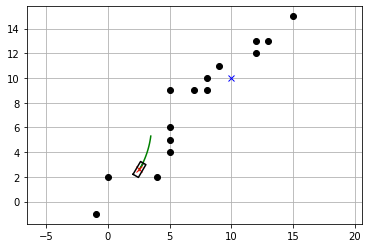

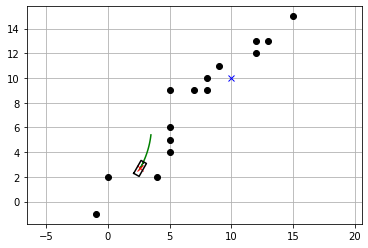

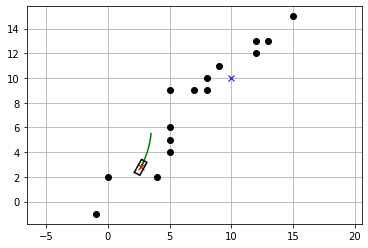

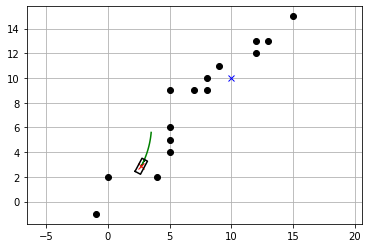

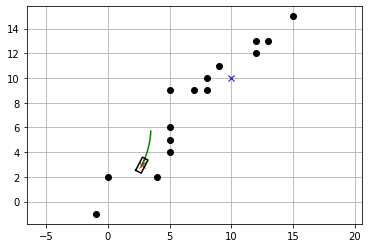

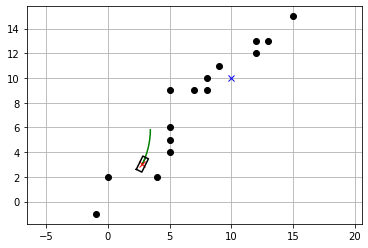

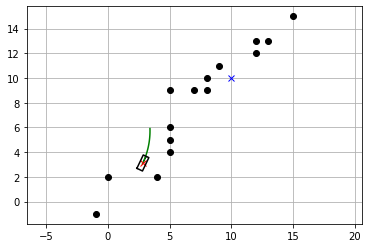

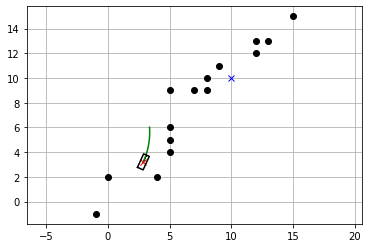

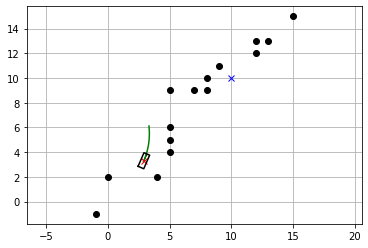

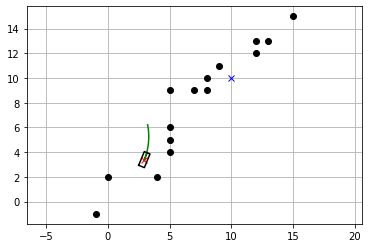

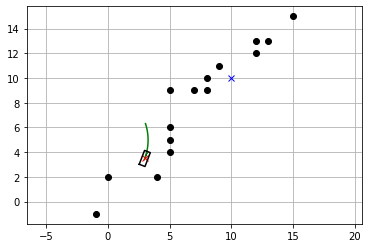

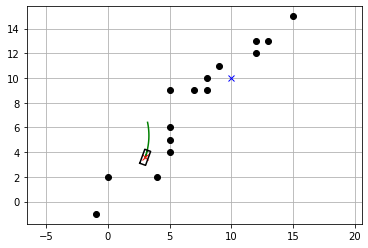

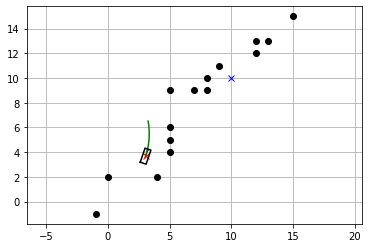

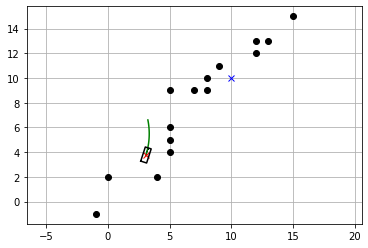

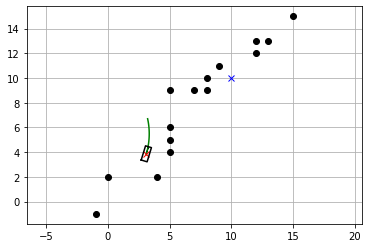

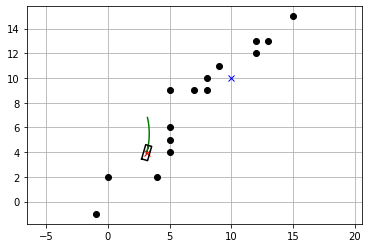

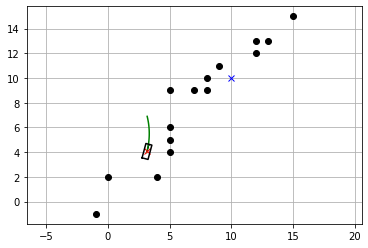

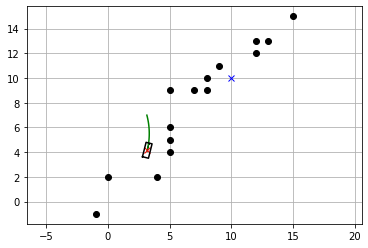

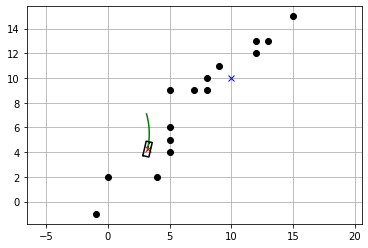

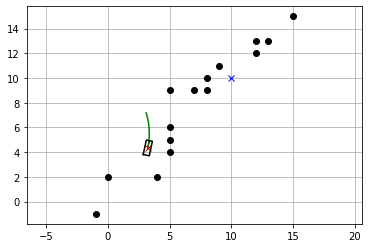

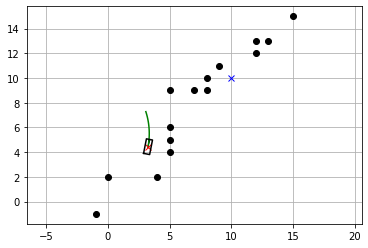

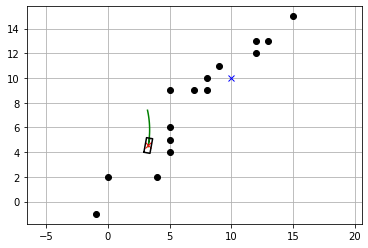

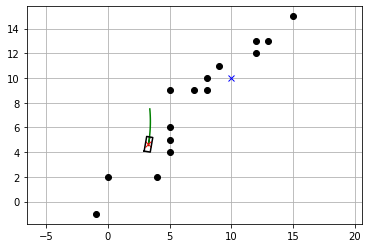

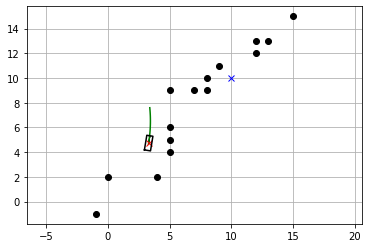

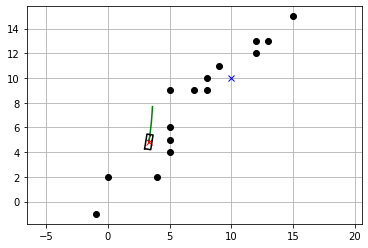

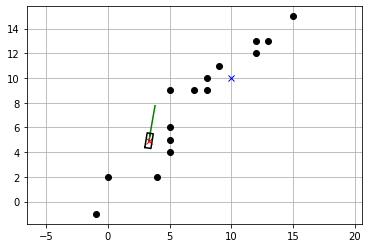

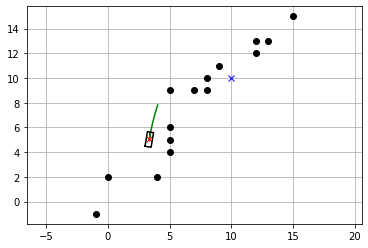

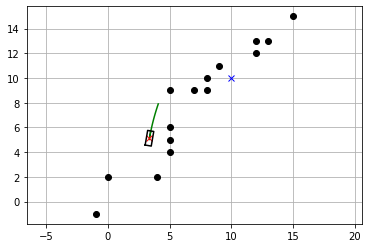

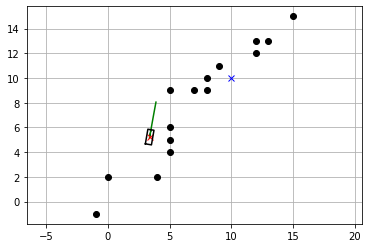

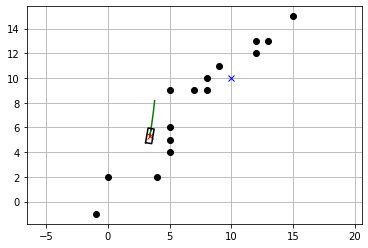

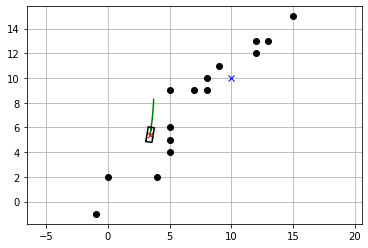

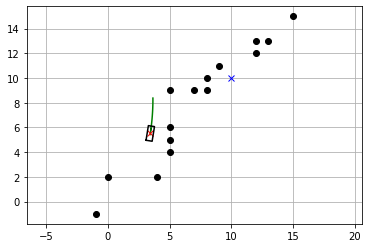

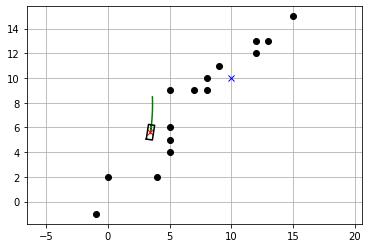

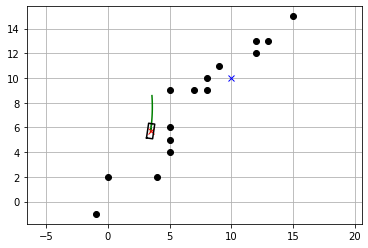

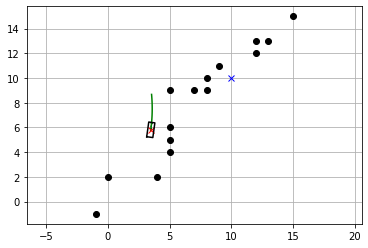

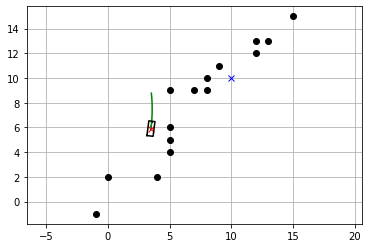

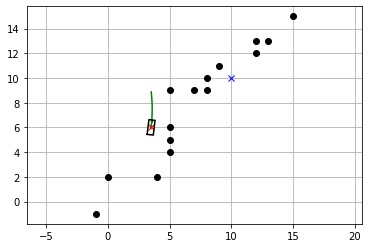

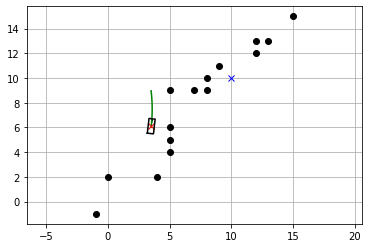

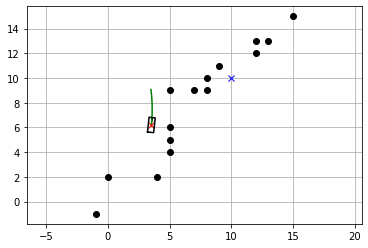

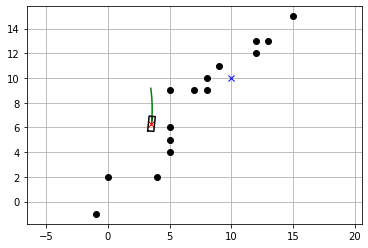

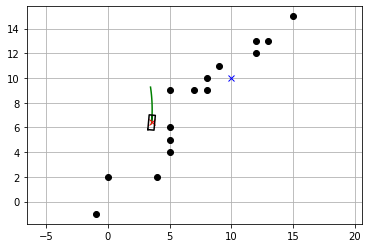

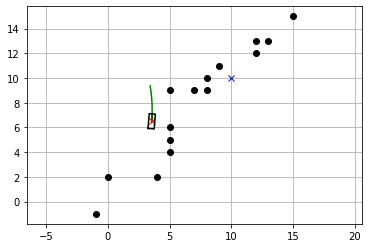

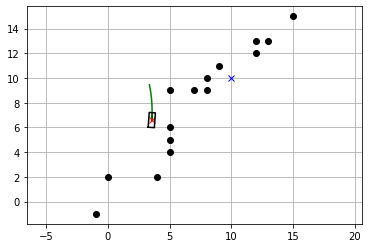

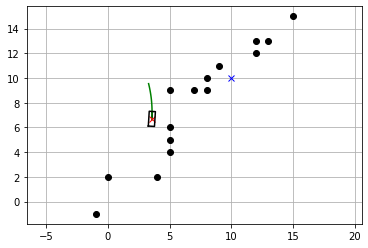

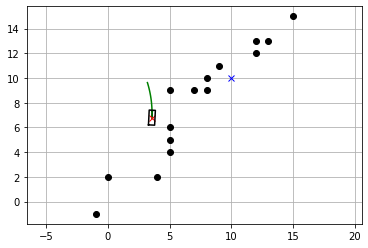

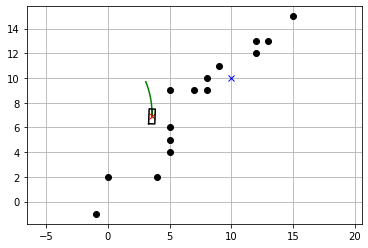

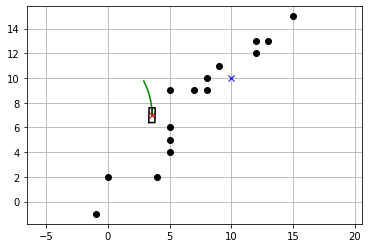

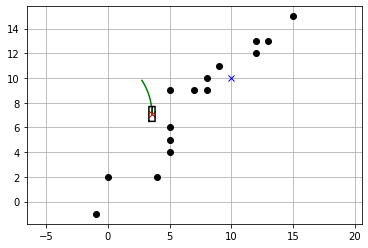

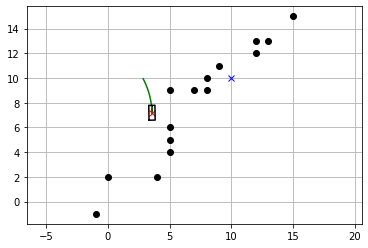

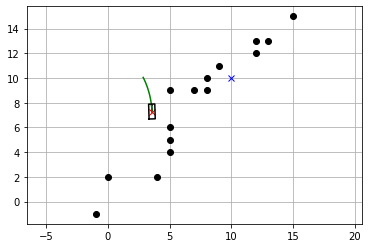

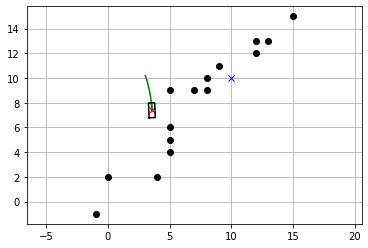

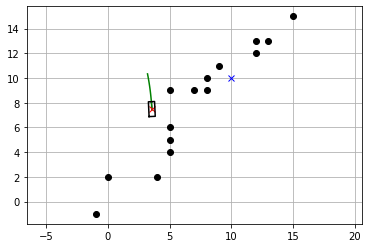

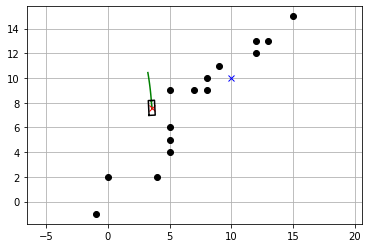

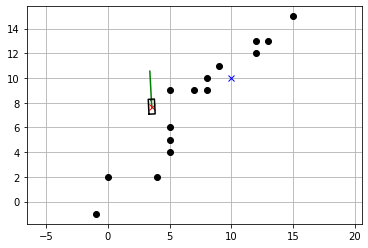

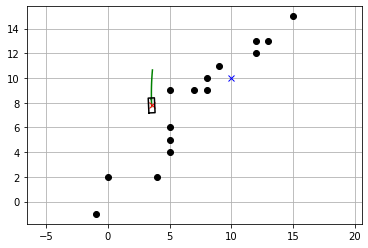

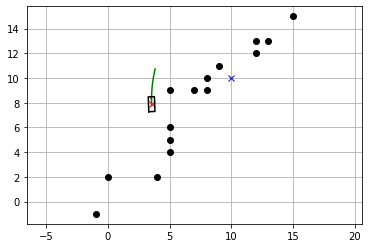

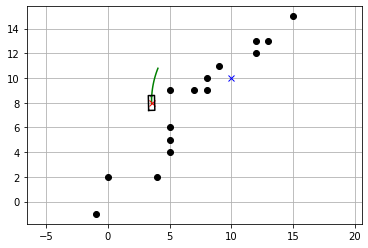

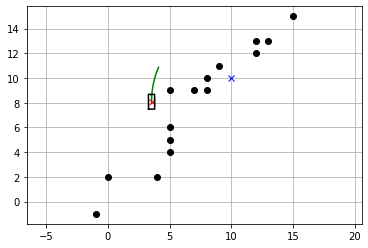

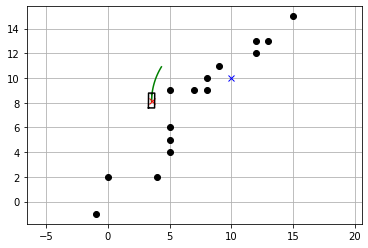

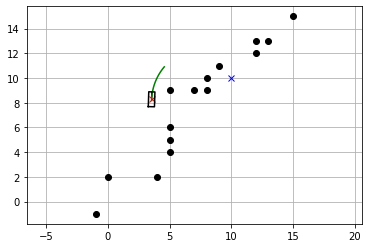

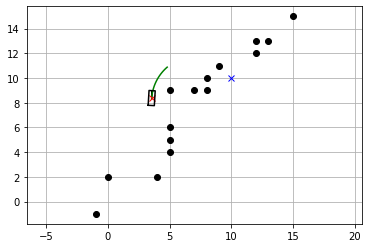

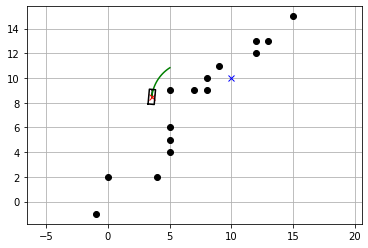

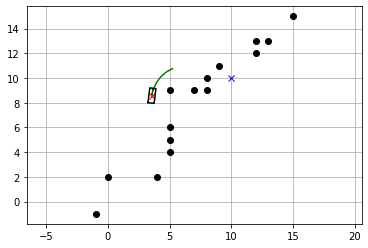

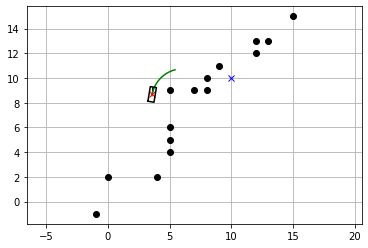

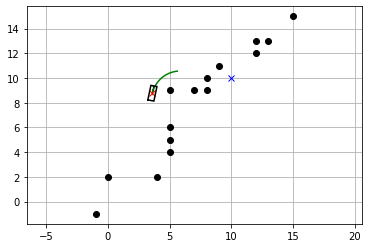

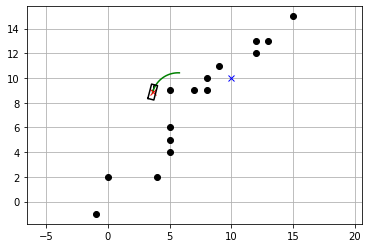

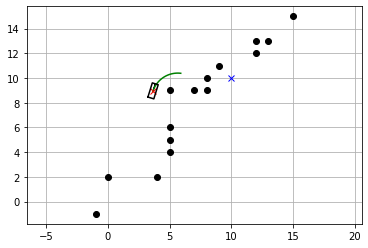

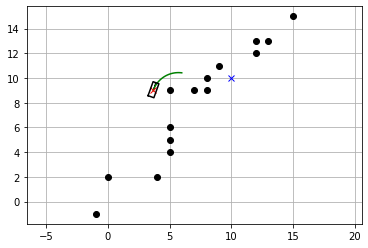

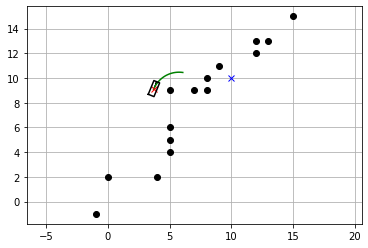

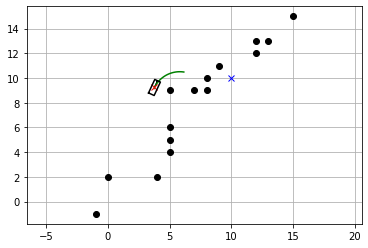

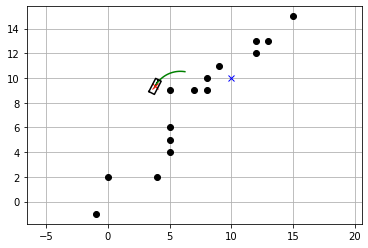

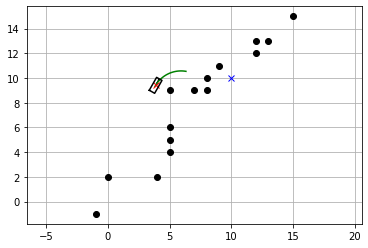

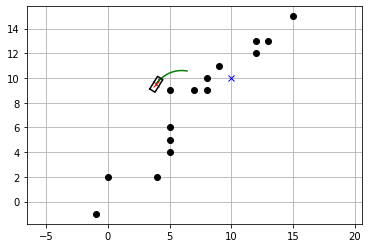

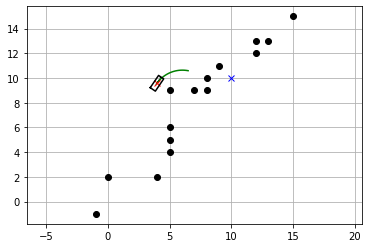

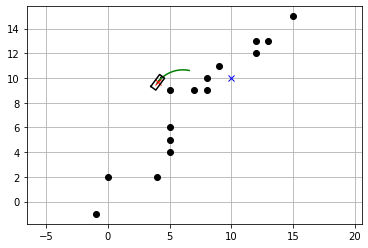

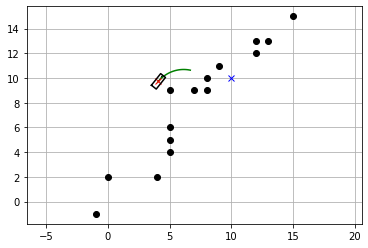

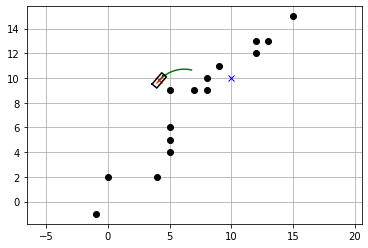

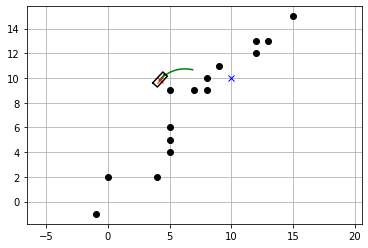

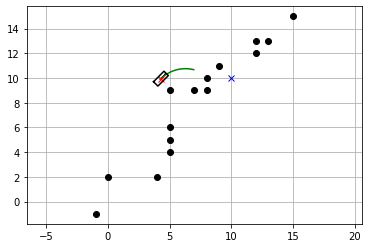

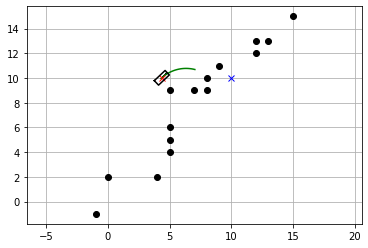

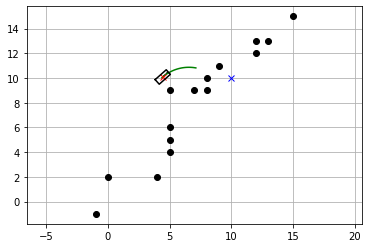

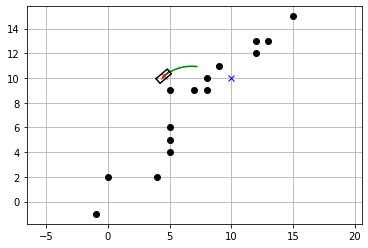

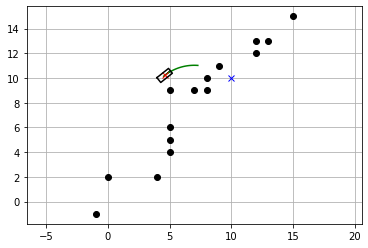

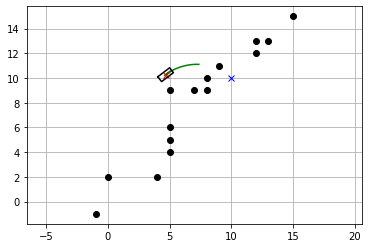

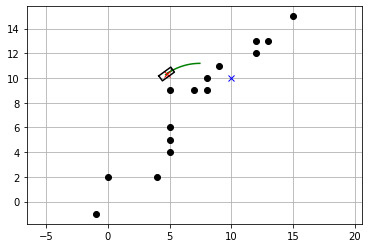

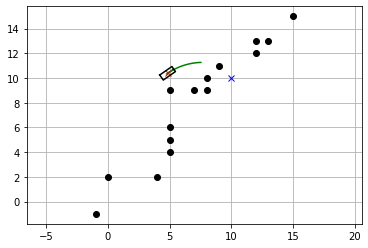

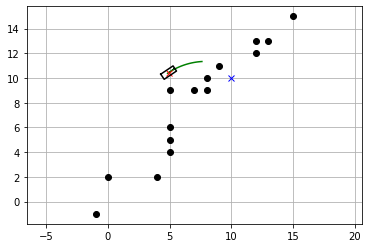

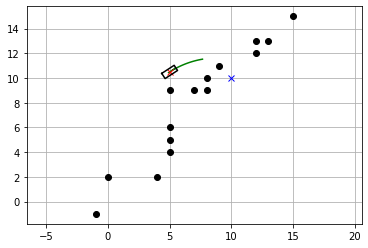

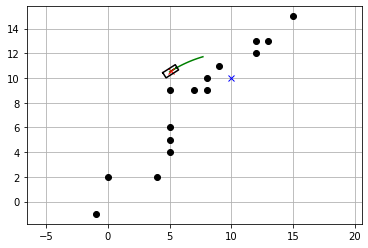

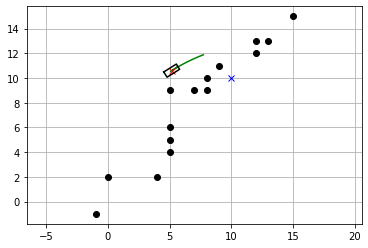

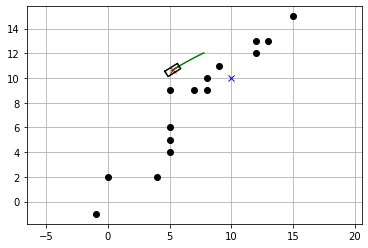

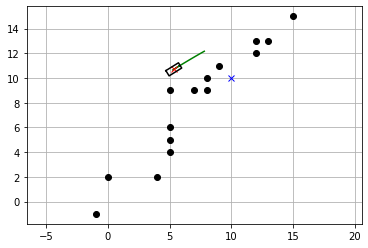

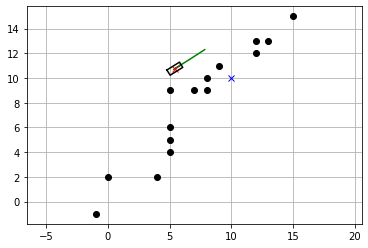

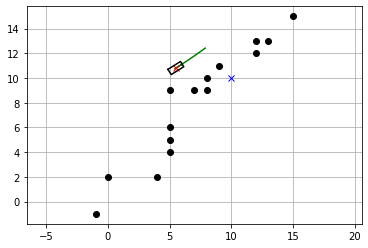

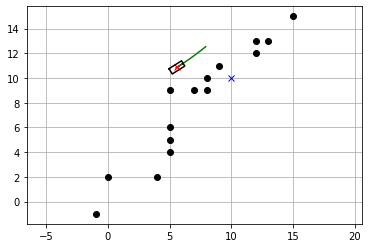

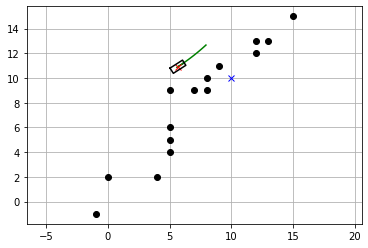

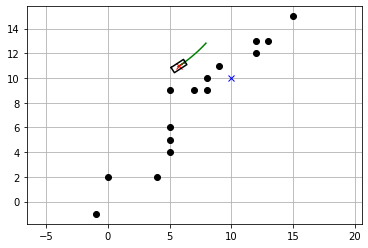

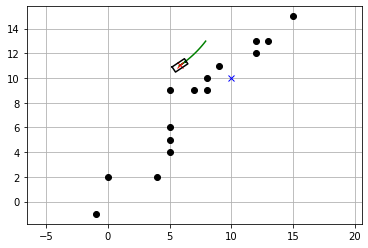

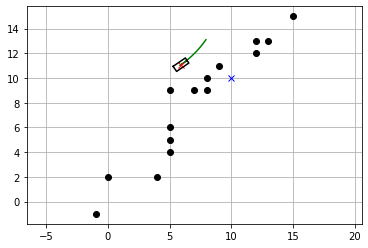

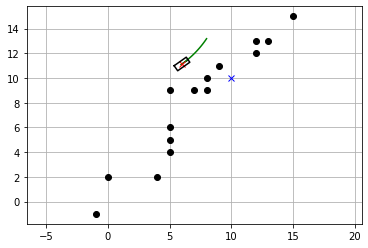

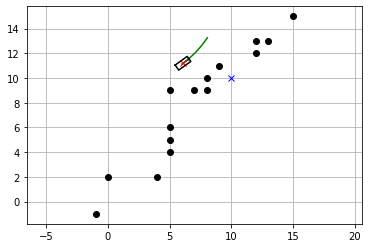

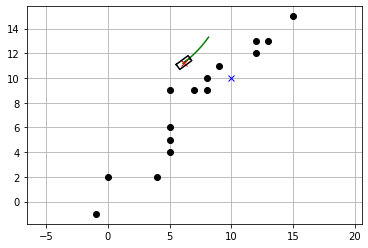

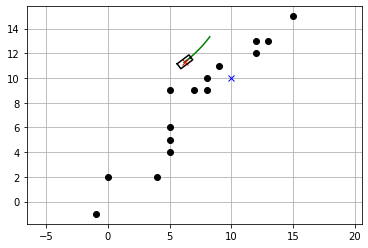

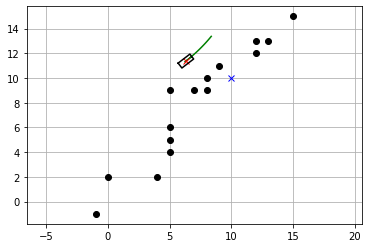

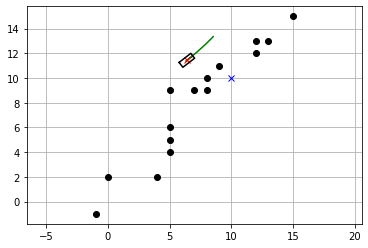

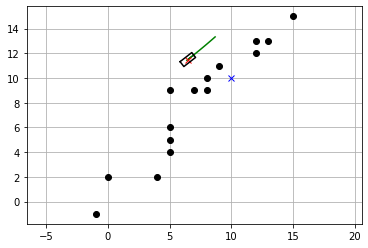

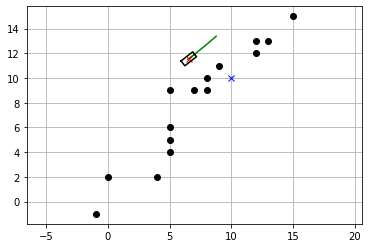

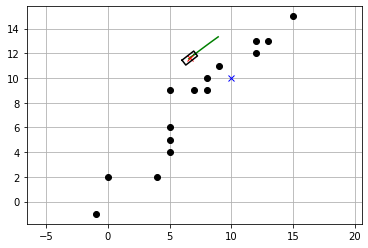

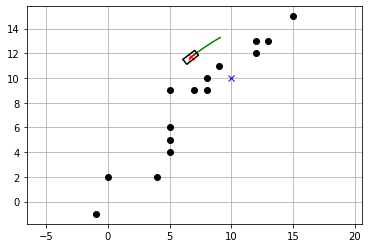

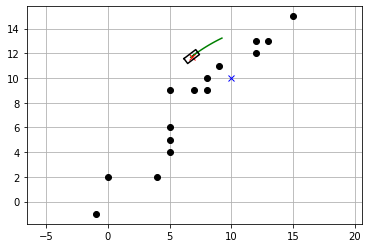

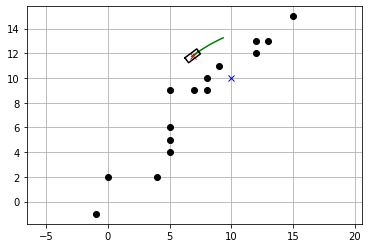

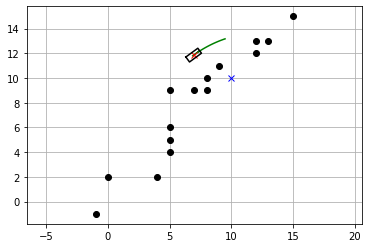

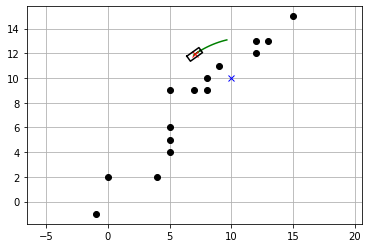

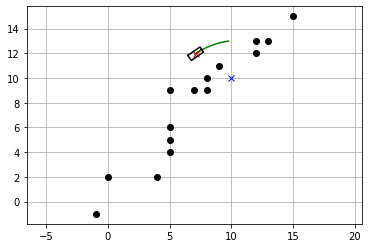

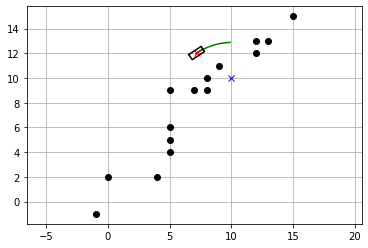

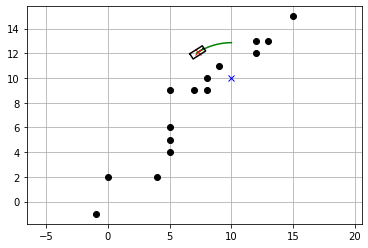

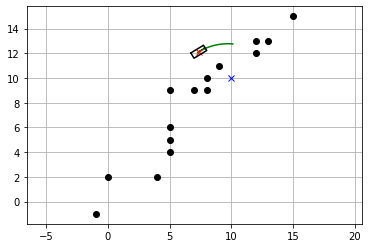

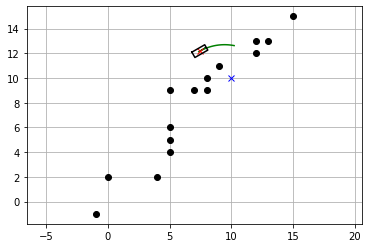

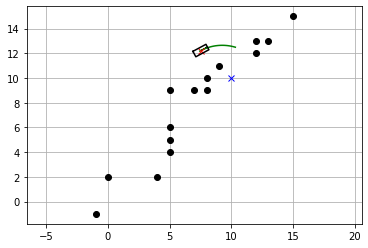

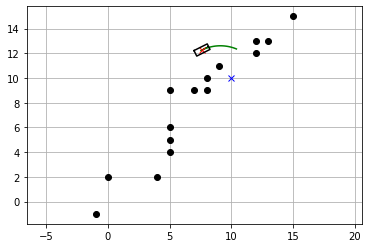

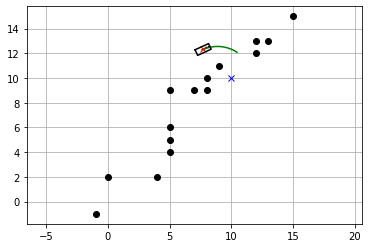

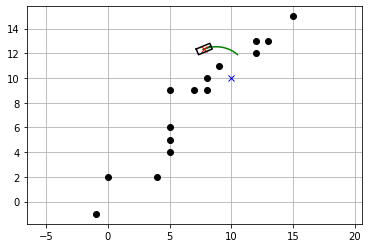

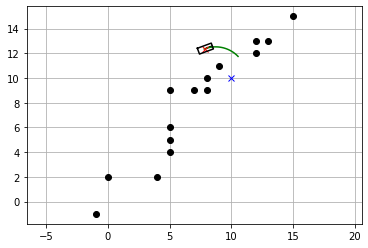

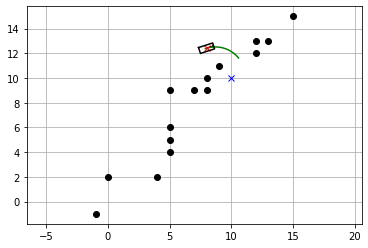

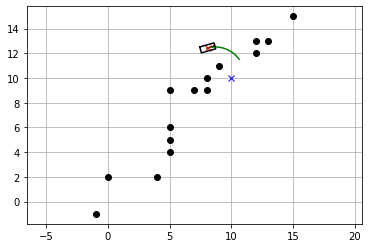

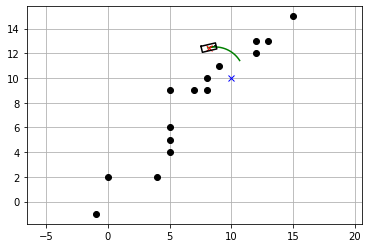

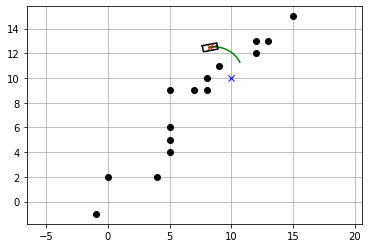

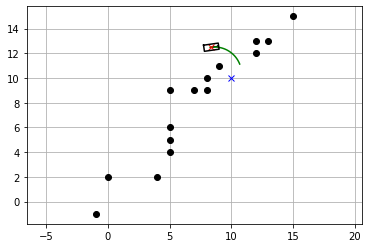

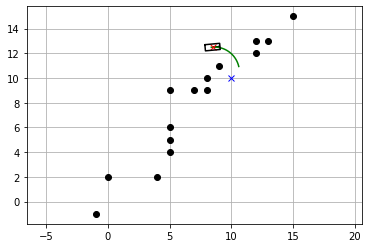

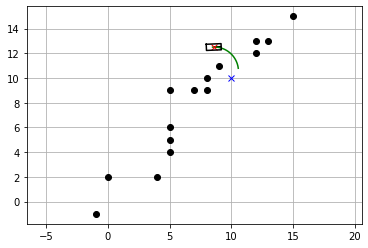

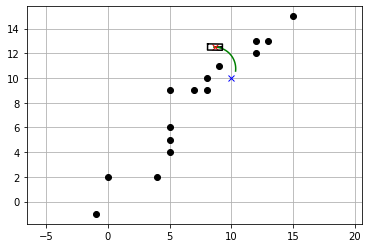

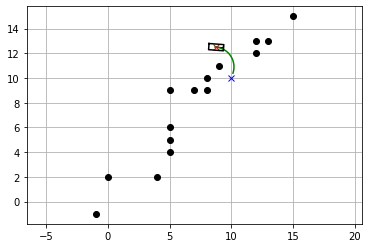

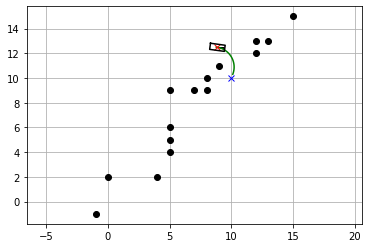

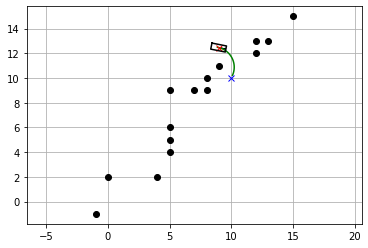

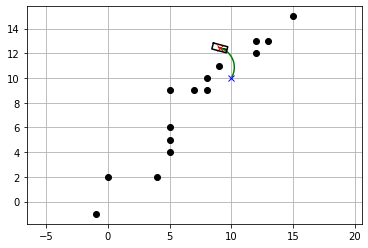

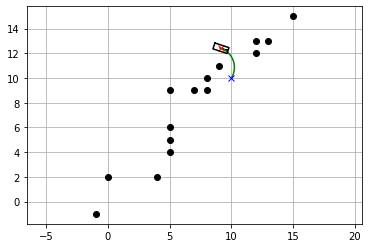

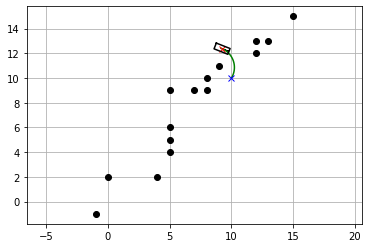

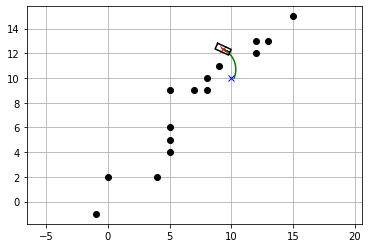

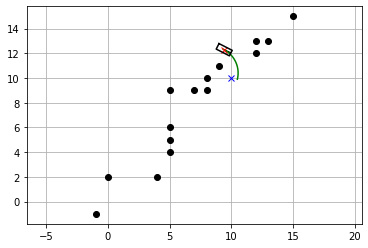

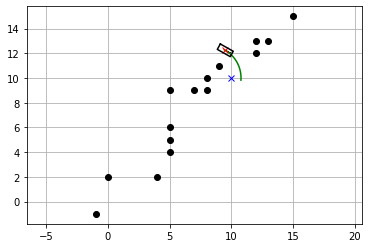

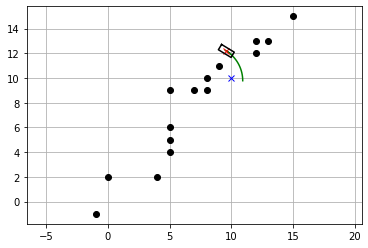

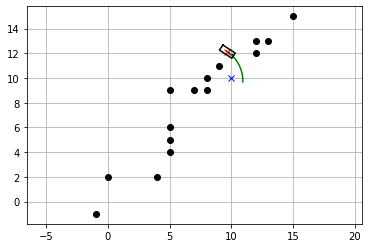

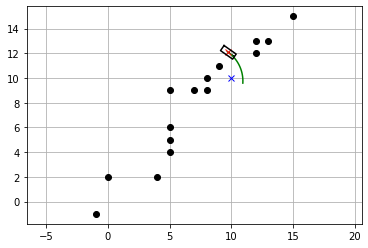

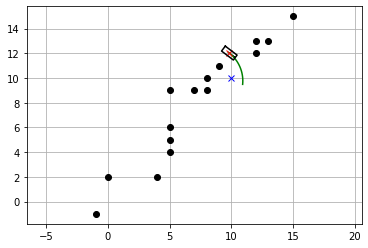

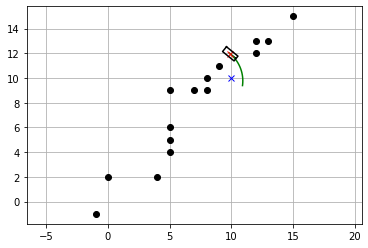

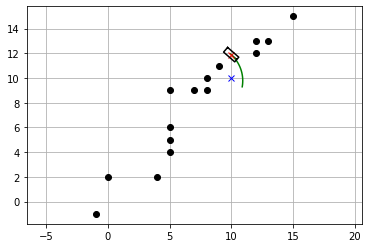

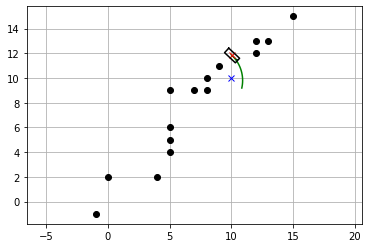

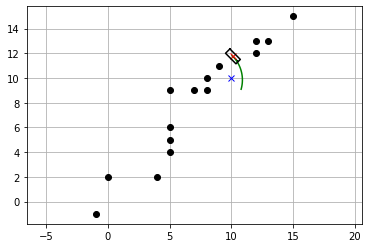

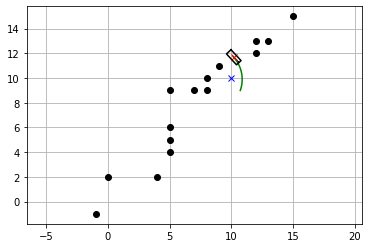

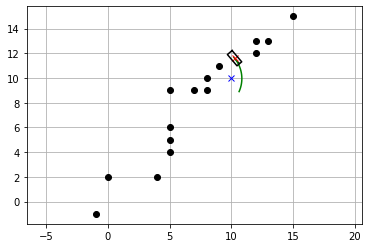

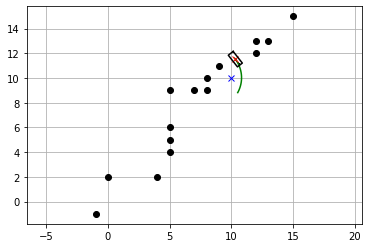

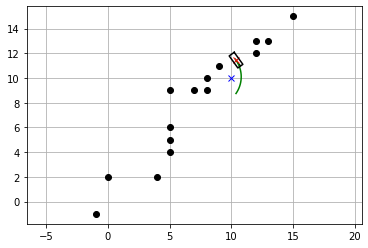

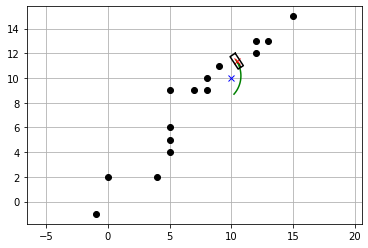

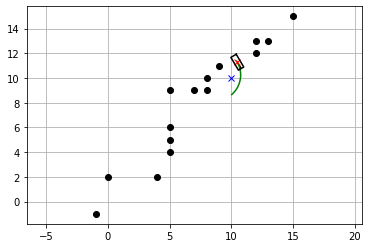

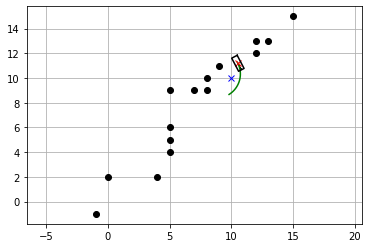

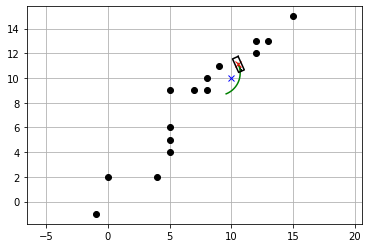

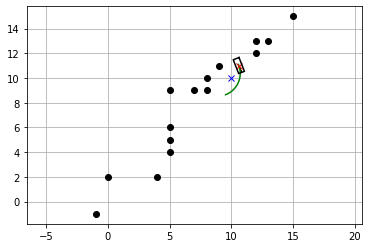

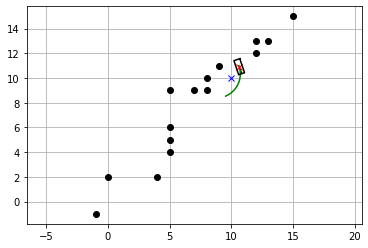

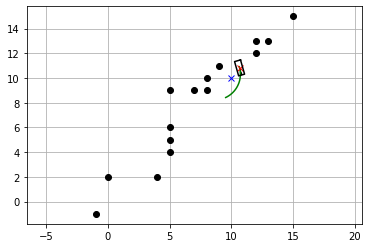

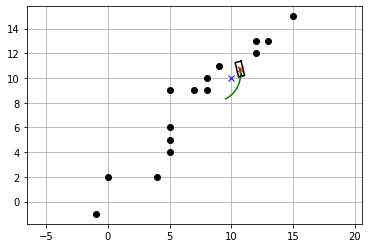

Goal!!
Done


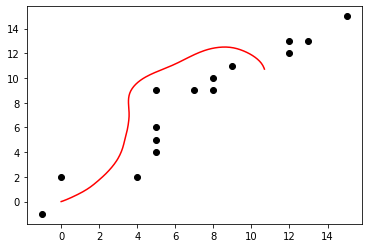

In [ ]:
main(robot_type=RobotType.rectangle)